Train SVM for each finger pair!\
Data source: \
sliding windowed powers for mu and beta band\
Subject 1

In [1]:
import os
import numpy as np
import h5py
import mne
from scipy import stats
import scipy.io
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib.ticker import FuncFormatter

mne.set_log_level('error')

from tqdm.notebook import tqdm


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


from utils.load import Load
from config.default import cfg

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2


In [2]:
subject_id = 4
tag = '0_25powers' # contains bad

In [3]:
# Load the dictionary from the HDF5 file
target_dir = 'features'
file_path = os.path.join(target_dir, tag + '_' + cfg['subjects'][subject_id] + '.h5')


data = {}
with h5py.File(file_path, 'r') as h5file:
    for key in h5file.keys():
        data[key] = np.array(h5file[key])

# Print the loaded data dictionary
for key, value in data.items():
    print(key, value.shape)

time_stamps = data['index'].shape[-2]
print(time_stamps)

index (50, 158, 30, 2)
little (50, 158, 30, 2)
middle (50, 158, 30, 2)
ring (50, 158, 30, 2)
thumb (50, 158, 30, 2)
30


In [4]:
def train_SVM(finger1, finger2, local_data):
    #print(f'Training SVM for {finger1} vs {finger2}')

    X = np.concatenate((local_data[finger1], local_data[finger2]), axis=0)
    y = np.concatenate((np.ones(data[finger1].shape[0]), np.zeros(data[finger2].shape[0])), axis=0)


    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    tuned_parameters = [{'kernel': ['linear','rbf'], 'gamma': [1e-3, 1e-4, 1e-5, 1e-6],
                         'C': [ 1,10,100]}]
    grid = GridSearchCV(SVC(), tuned_parameters, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
    grid.fit(X, y)
    acc = grid.best_score_* 100
    # print(str(round(acc, 2)))
    # print(grid.best_params_)
    return acc

  0%|          | 0/30 [00:00<?, ?it/s]

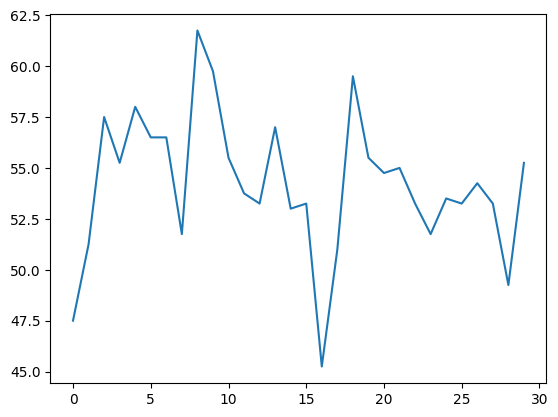

In [5]:
# Summerize all finger pairs all timestamps



accs = []

def search(start):
    #print(start)
    data_segment = data.copy()
    for key, value in data_segment.items():
        asd = value[:, : ,start:start+1]
        data_segment[key] = asd.reshape(asd.shape[0], -1)
        
    accuracies = []
    finger1 = 'ring'
    for finger2 in data_segment:
        if finger1 != finger2:
            accuracies.append(train_SVM(finger1, finger2, data_segment))
      
    accucarcies = np.array(accuracies)
    # print(f'Average accuracy: {np.mean(accuracies)}')
    # print(f'Standard deviation: {np.std(accuracies)}')
    return np.mean(accuracies)

for i in tqdm(range(0, time_stamps)):
    accs.append(search(i))
accs = np.array(accs)

plt.plot(accs)

In [6]:

accs = []


def ring_search():
    result = {}
    finger1 = 'ring'
    for finger2 in data:
        if finger1 != finger2:
            print(finger1, finger2)

          
            accuracies = []
            # Iterate over all time stamps
            for start in tqdm(range(0, time_stamps)):
                data_segment = deepcopy(data)
                for key, value in data_segment.items():
                    asd = value[:, : ,start:start+1]
                    data_segment[key] = asd.reshape(asd.shape[0], -1)


                accuracies.append(train_SVM(finger1, finger2, data_segment))

            accuracies = np.array(accuracies)
            result[finger2] = accuracies
            # plt.plot(accuracies)
            # plt.show()
            # plt.savefig(f'SVM_time_segments/ring_{finger2}.png')
         
    return result

results = ring_search()

ring index


  0%|          | 0/30 [00:00<?, ?it/s]

ring little


  0%|          | 0/30 [00:00<?, ?it/s]

ring middle


  0%|          | 0/30 [00:00<?, ?it/s]

ring thumb


  0%|          | 0/30 [00:00<?, ?it/s]

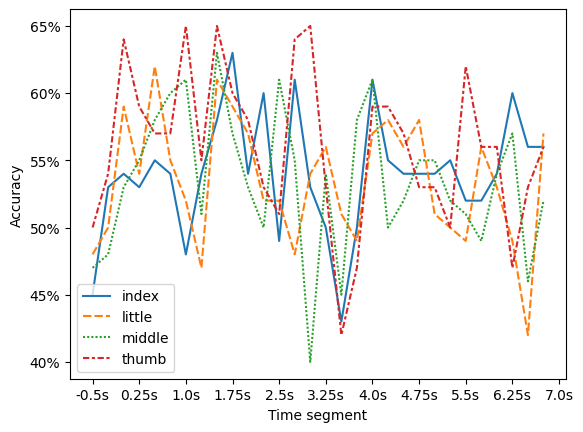

In [7]:
# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(results, orient='index').T
df = df/100


# Plot using Seaborn
ax = sns.lineplot(data=df)

# Set y-axis tick labels
x_labels = np.arange(-0.5, 7.5, 7.5/10)
x_labels = [f'{str(x)}s' for x in x_labels]
x_ticks = np.linspace(0, 30, num=len(x_labels))

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

# Set y-axis tick labels as percentages
def percentage(x, pos):
    return '{:.0%}'.format(x)

formatter = FuncFormatter(percentage)
ax.yaxis.set_major_formatter(formatter)


# Set axis labels
ax.set_xlabel('Time segment')
ax.set_ylabel('Accuracy')

plt.savefig(f'ring_plots/S{subject_id+1}_SVM_accuracy.png', dpi=1000)